In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from rosbags.rosbag1 import Reader

from rosbags.rosbag1 import Writer

from rosbags.typesys import Stores, get_types_from_msg,  get_typestore

In [2]:
import pymap3d as pm

In [3]:
path_bagfiles = 'data/'
path_bag = os.path.join(path_bagfiles, '20190331HH.bag')
path_msgs = r'msgs'

In [4]:
# create reader instance and open for reading
with Reader(path_bag) as reader:
    # topic and msgtype information is available on .connections list
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)

/navsat/origin geometry_msgs/msg/Pose
/imu/data sensor_msgs/msg/Imu
/velodyne_points sensor_msgs/msg/PointCloud2
/camera/image_color sensor_msgs/msg/Image
/novatel_data/bestpos novatel_msgs/msg/BESTPOS
/navsat/fix sensor_msgs/msg/NavSatFix
/GNSS_ nlosExclusion/msg/GNSS_Raw_Array
/novatel_data/corrimudata novatel_msgs/msg/CORRIMUDATA
/novatel_data/inscov novatel_msgs/msg/INSCOV
/novatel_data/inspvax novatel_msgs/msg/INSPVAX
/navsat/odom nav_msgs/msg/Odometry


In [5]:
msg_register_map = {
                    'novatel_msgs/CommonHeader': 'novatel_header.msg',
                    'novatel_msgs/msg/INSPVAX': 'inspvax.msg' ,
                    }

typestore_ros = get_typestore(Stores.ROS1_NOETIC)

for topic, msg_def in msg_register_map.items():
    _msg_txt = Path(os.path.join(path_msgs, msg_def)).read_text()
    typestore_ros.register(get_types_from_msg(_msg_txt, topic))

In [6]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(msg)
            i+=1 
            if i > 2: break

sensor_msgs__msg__Imu(header=std_msgs__msg__Header(seq=111040, stamp=builtin_interfaces__msg__Time(sec=1554023732, nanosec=534768104, __msgtype__='builtin_interfaces/msg/Time'), frame_id='/imu', __msgtype__='std_msgs/msg/Header'), orientation=geometry_msgs__msg__Quaternion(x=0.008490901440382004, y=0.0068376571871340275, z=0.43763354420661926, w=0.8990872502326965, __msgtype__='geometry_msgs/msg/Quaternion'), orientation_covariance=array([0.01745, 0.     , 0.     , 0.     , 0.01745, 0.     , 0.     ,
       0.     , 0.15708]), angular_velocity=geometry_msgs__msg__Vector3(x=0.005884075537323952, y=0.010338467545807362, z=-0.009073294699192047, __msgtype__='geometry_msgs/msg/Vector3'), angular_velocity_covariance=array([0.0004, 0.    , 0.    , 0.    , 0.0004, 0.    , 0.    , 0.    ,
       0.0004]), linear_acceleration=geometry_msgs__msg__Vector3(x=0.23419667780399323, y=-0.05404794216156006, z=9.329668998718262, __msgtype__='geometry_msgs/msg/Vector3'), linear_acceleration_covariance=ar

In [7]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(timestamp*1e-9, msg)
            i+=1 
            if i > 2: break

1556244170.171823 novatel_msgs__msg__INSPVAX(header=novatel_msgs__msg__CommonHeader(id=1465, msg_type=0, port_addr=64, length=126, sequence=0, idle_time=131, time_status=180, gps_week=2047, gps_week_seconds=33350000, receiver_status=2048, reserved=19988, software_version=13754, RECEIVER_STATUS_ERROR=1, RECEIVER_STATUS_TEMPERATURE_WARNING=2, RECEIVER_STATUS_VOLTAGE_SUPPLY_WARNING=4, RECEIVER_STATUS_ANTENNA_UNPOWERED=8, RECEIVER_STATUS_LNA_FAILURE=16, RECEIVER_STATUS_ANTENNA_OPEN=32, RECEIVER_STATUS_ANTENNA_SHORTED=64, RECEIVER_STATUS_CPU_OVERLOADED=128, RECEIVER_STATUS_COM1_BUFFER_OVERRUN=256, RECEIVER_STATUS_COM2_BUFFER_OVERRUN=512, RECEIVER_STATUS_COM3_BUFFER_OVERRUN=1024, RECEIVER_STATUS_LINK_OVERLOAD=2048, RECEIVER_STATUS_AUX_TRANSMIT_OVERRUN=8192, RECEIVER_STATUS_AGC_OUT_OF_RANGE=16384, RECEIVER_STATUS_INS_RESET=65536, RECEIVER_STATUS_ALMANAC_INVALID=262144, RECEIVER_STATUS_POSITION_SOLUTION_INVALID=524288, RECEIVER_STATUS_POSITION_NOT_FIXED=1048576, RECEIVER_STATUS_CLOCK_STEERING_

In [8]:
# https://github.com/IPNL-POLYU/UrbanNavDataset/blob/master/docs/GETTING_STARTED.md
SECONDS_IN_GPS_WEEK = 604800.0
def gps2utc(gps_week, gps_seconds):
    utctime = (gps_week * SECONDS_IN_GPS_WEEK + gps_seconds-18) + 315964800
    return utctime

In [9]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(gps2utc(msg.header.gps_week, msg.header.gps_week_seconds*1e-3))
            i+=1 
            if i > 2: break

1554023732.0
1554023733.0
1554023734.0


In [10]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(msg.header.stamp.sec, msg.header.stamp.nanosec)
            i+=1 
            if i > 2: break

1554023732 534768104
1554023732 544745922
1554023732 554702043


In [11]:
header_imu = ['time','time_sec', 'time_ns', 
            'gx', 'gy', 'gz', 
            'ax', 'ay', 'az']

header_gnss = ['time', 'time_sec', 'time_ns', 've', 'vn', 'vu', 'azimuth', 'lat', 'lon', 'alt']

In [12]:
imu = []
gnss = []

In [13]:
with Reader(path_bag) as reader:

    for connection, timestamp, rawdata in reader.messages():
        
        if connection.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, connection.msgtype)
            t = msg.header.stamp.sec + msg.header.stamp.nanosec*1e-9
            imu.append([
                t, msg.header.stamp.sec, msg.header.stamp.nanosec,
                msg.angular_velocity.x, msg.angular_velocity.y, msg.angular_velocity.z,
                msg.linear_acceleration.x, msg.linear_acceleration.y, msg.linear_acceleration.z])
        elif connection.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, connection.msgtype)
            t = gps2utc(msg.header.gps_week, msg.header.gps_week_seconds*1e-3)
            _sec = int(t)
            _nanosec = (t -_sec) * 1e9
            gnss.append([
                t,_sec, _nanosec,
                msg.east_velocity, msg.north_velocity, msg.up_velocity,
                msg.azimuth, msg.latitude, msg.longitude, msg.altitude])


In [14]:
df_imu = pd.DataFrame(imu, columns=header_imu)
df_gnss = pd.DataFrame(gnss, columns=header_gnss)

In [15]:
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935


In [16]:
df_imu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15097 entries, 0 to 15096
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      15097 non-null  float64
 1   time_sec  15097 non-null  int64  
 2   time_ns   15097 non-null  int64  
 3   gx        15097 non-null  float64
 4   gy        15097 non-null  float64
 5   gz        15097 non-null  float64
 6   ax        15097 non-null  float64
 7   ay        15097 non-null  float64
 8   az        15097 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.0 MB


In [17]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605


In [18]:
df_gnss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      151 non-null    float64
 1   time_sec  151 non-null    int64  
 2   time_ns   151 non-null    float64
 3   ve        151 non-null    float64
 4   vn        151 non-null    float64
 5   vu        151 non-null    float64
 6   azimuth   151 non-null    float64
 7   lat       151 non-null    float64
 8   lon       151 non-null    float64
 9   alt       151 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 11.9 KB


In [19]:
# Define an initial time
t0 = min(df_imu['time'].iloc[0], df_gnss['time'].iloc[0])
# Keep track of relative time - for plots 
df_imu['t_rel'] = df_imu['time'] - t0
df_gnss['t_rel'] = df_gnss['time'] - t0

In [20]:
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az,t_rel
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669,0.534768
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809,0.544746
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268,0.554702
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576,0.564667
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935,0.574855


In [21]:
T = 1/100 # sample rate
# Multiple acceleration and rotation rates by sampling time
for param in ['a', 'g']:
    for dir in ['x', 'y', 'z']:
            df_imu[param+dir+'dt'] = df_imu[param+dir] * T

In [22]:
df_imu['adt'] = np.sqrt(np.square(df_imu['axdt']) + np.square(df_imu['aydt']) + np.square(df_imu['azdt']))
df_imu['gdt'] = np.sqrt(np.square(df_imu['gxdt']) + np.square(df_imu['gydt']) + np.square(df_imu['gzdt']))
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az,t_rel,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669,0.534768,0.002342,-0.000540,0.093297,0.000059,0.000103,-0.000091,0.093328,0.000150
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809,0.544746,0.001771,0.003380,0.098988,0.000035,-0.000055,-0.000036,0.099062,0.000074
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268,0.554702,-0.002513,0.004239,0.102463,-0.000053,0.000048,-0.000018,0.102581,0.000074
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576,0.564667,-0.000838,0.001449,0.096336,-0.000028,0.000033,-0.000116,0.096350,0.000124
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935,0.574855,0.002996,-0.000243,0.093739,0.000005,0.000095,-0.000033,0.093788,0.000101


Text(375.06944444444446, 0.5, '$\\frac{rad}{s}$')

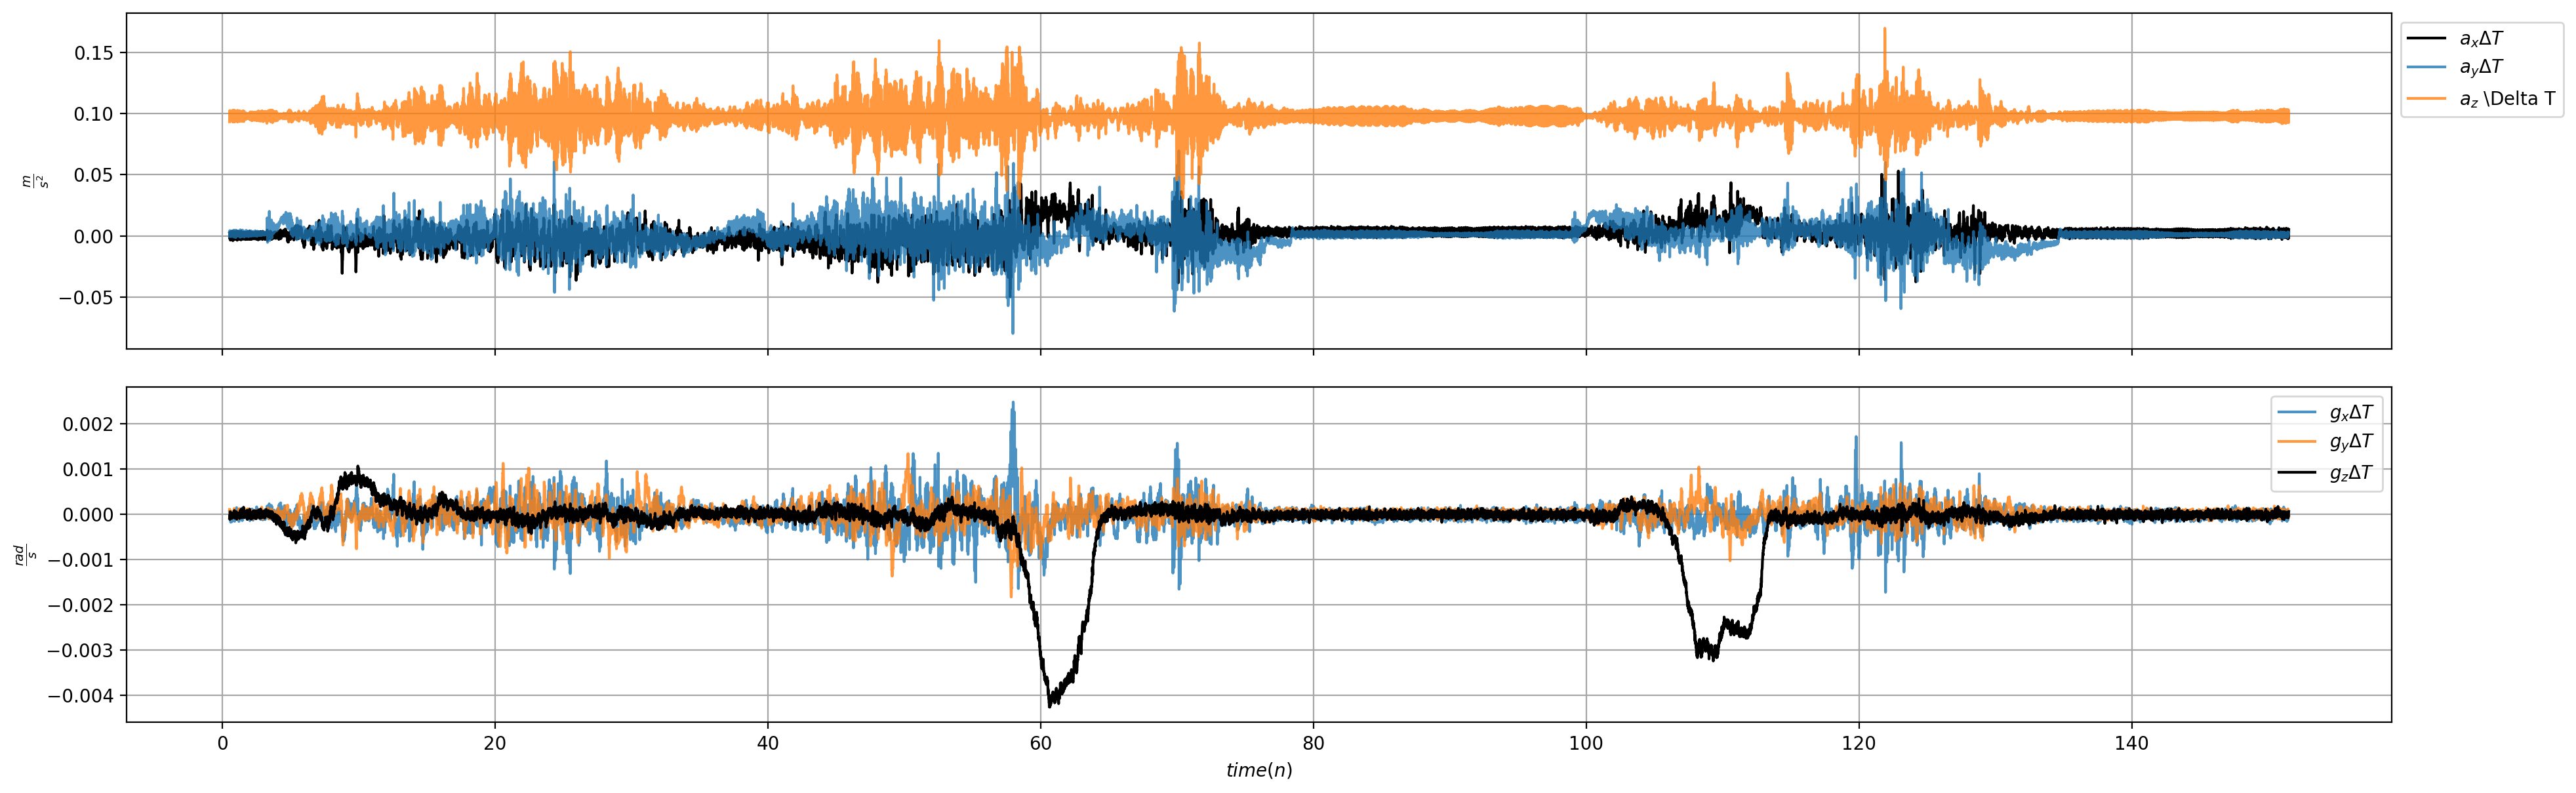

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,6),dpi=200, sharex='col')
fig.tight_layout()

ax1.plot(df_imu['t_rel'], df_imu['axdt'],  label=r'$a_x \Delta T$', color='k')
ax1.plot(df_imu['t_rel'], df_imu['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
ax1.plot(df_imu['t_rel'], df_imu['azdt'],  label=r'$a_z$ \Delta T', alpha=0.8)

ax1.legend(bbox_to_anchor=[1,1])
ax1.grid(True, which='both',ls='-',color='0.65')
ax1.set_ylabel(r'$\frac{m}{s^2}$')

ax2.plot(df_imu['t_rel'], df_imu['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
ax2.plot(df_imu['t_rel'], df_imu['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
ax2.plot(df_imu['t_rel'], df_imu['gzdt'],  label=r'$g_z \Delta T$', color='k')

ax2.legend(bbox_to_anchor=[1,1])
ax2.grid(True, which='both',ls='-',color='0.65')

ax2.set_xlabel(r'$time(n)$')
ax2.set_ylabel(r'$\frac{rad}{s}$')

In [24]:
# Keep a copy of gnss_index, this is for later join operations
df_gnss['gnss_index'] = df_gnss.index.to_numpy()
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,0.0,0
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,1.0,1
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,2.0,2
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,3.0,3
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,4.0,4


In [25]:
_N_gnss = df_gnss.index.size
df_gnss['E'], df_gnss['N'], df_gnss['U'] = zip(*df_gnss.apply(
                                                        lambda x : pm.geodetic2enu(x['lat'], x['lon'], x['alt'],
                                                                                   df_gnss['lat'].iloc[int(_N_gnss/2)], df_gnss['lon'].iloc[int(_N_gnss/2)], df_gnss['alt'].iloc[int(_N_gnss/2)]
                                                                                   ), axis=1
))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


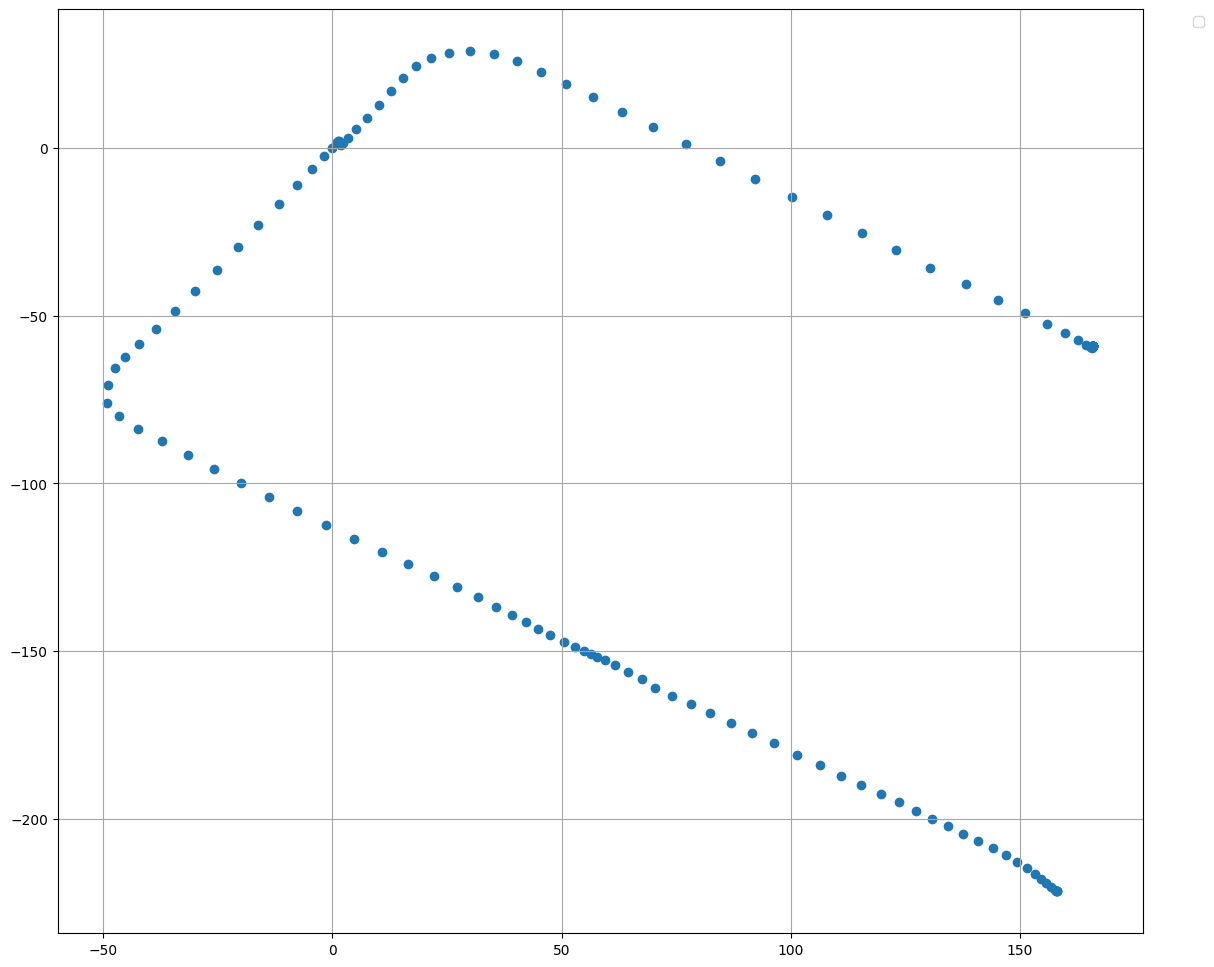

In [26]:
fig, ax = plt.subplots(figsize=(14,12))

ax.scatter(df_gnss['E'], df_gnss['N'])

ax.grid(True, which='both',ls='-',color='0.65')
ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')

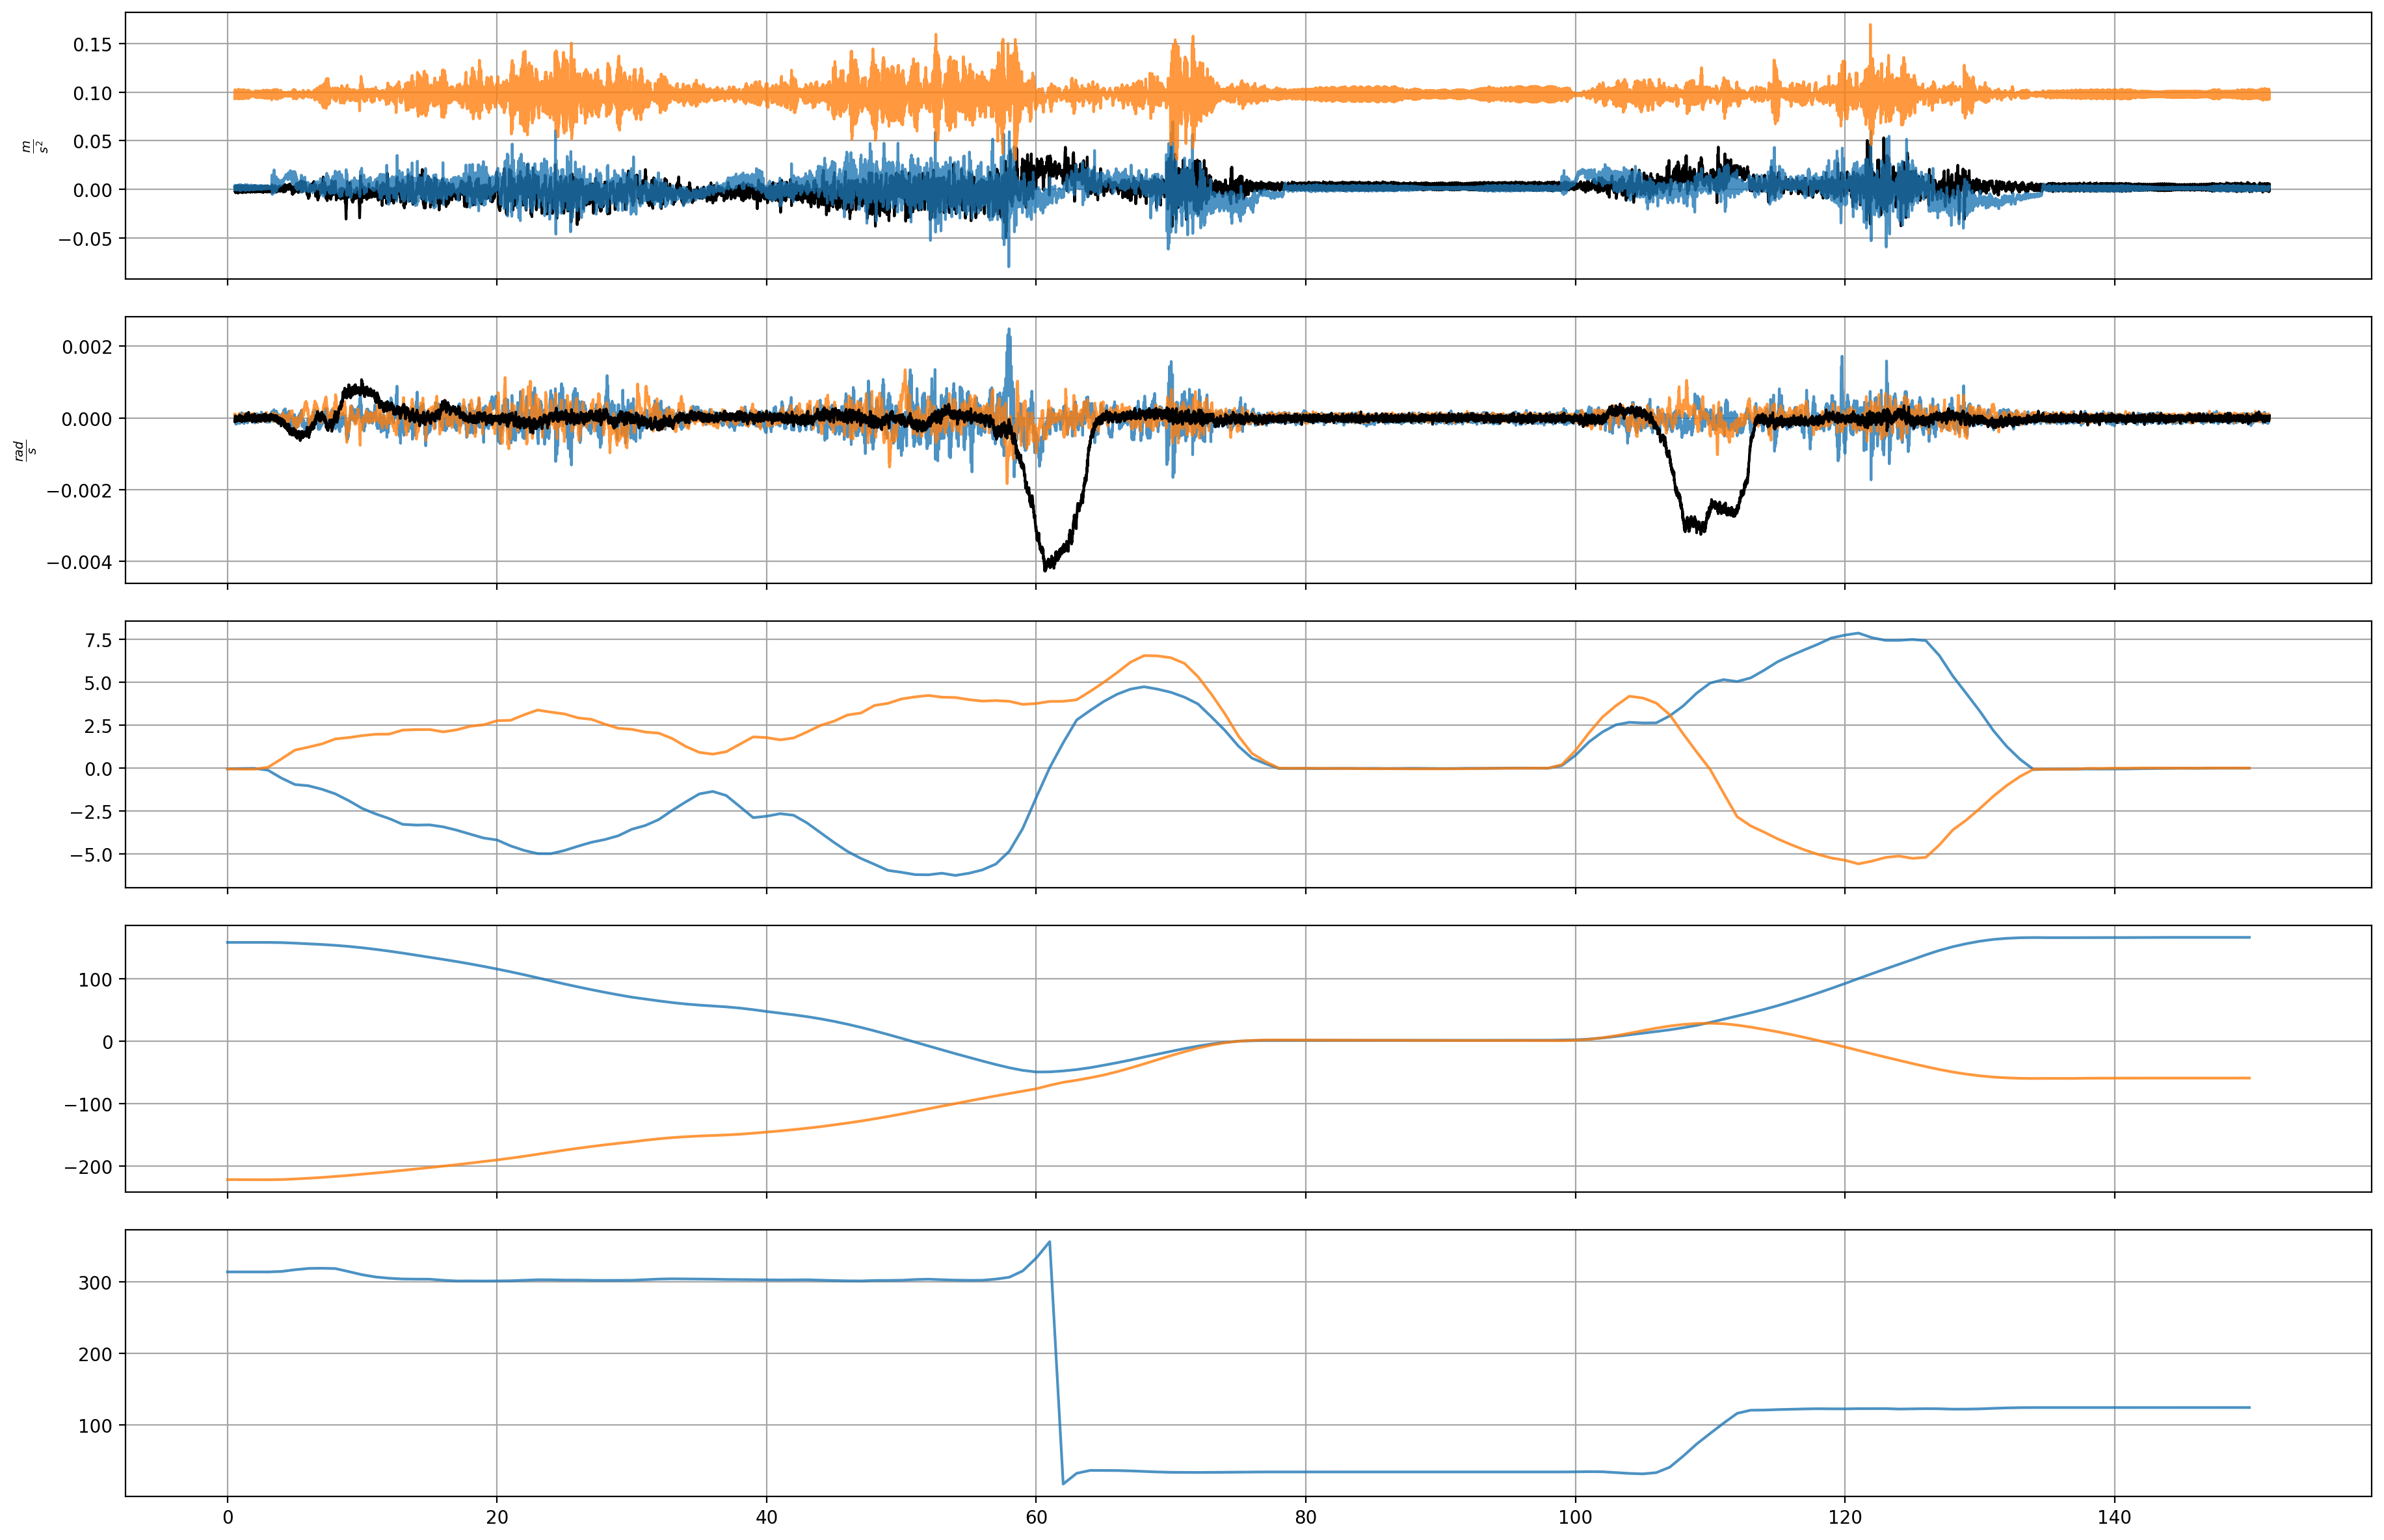

In [27]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(18,12),dpi=200, sharex='col')
fig.tight_layout()

axs[0].plot(df_imu['t_rel'], df_imu['axdt'],  label=r'$a_x \Delta T$', color='k')
axs[0].plot(df_imu['t_rel'], df_imu['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
axs[0].plot(df_imu['t_rel'],  df_imu['azdt'], label=r'$a_z \Delta T$', alpha=0.8)


axs[0].set_ylabel(r'$\frac{m}{s^2}$')

axs[1].plot(df_imu['t_rel'], df_imu['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
axs[1].plot(df_imu['t_rel'], df_imu['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
axs[1].plot(df_imu['t_rel'], df_imu['gzdt'],  label=r'$g_z \Delta T$', color='k')

axs[1].set_ylabel(r'$\frac{rad}{s}$')


axs[2].plot(df_gnss['t_rel'], df_gnss['ve'],  label=r'$Ve$', alpha=0.8)
axs[2].plot(df_gnss['t_rel'], df_gnss['vn'],  label=r'$Vn$', alpha=0.8)

axs[3].plot(df_gnss['t_rel'], df_gnss['E'],  label=r'$Ve$', alpha=0.8)
axs[3].plot(df_gnss['t_rel'], df_gnss['N'],  label=r'$Vn$', alpha=0.8)


axs[4].plot(df_gnss['t_rel'], df_gnss['azimuth'],  label=r'$Ve$', alpha=0.8)


for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')


Correlation between Velocity, and gyroscope, and accelerometer acitivity. Also some correlation between Azimuth and gyroscope data. Infact, accelerometer and gyroscope measure the cause of velocity changes and gyroscope measures cause of accelerometer change.

In [28]:
df_gnss['speed'] = np.sqrt(np.square(df_gnss['ve']) + np.square(df_gnss['vn']) + np.square(df_gnss['vu']))
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,0.0,0,158.041110,-221.354305,-2.793024,0.060602
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,1.0,1,158.083880,-221.458712,-2.782896,0.065327
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,2.0,2,158.075701,-221.524258,-2.764028,0.062689
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,3.0,3,158.059610,-221.571997,-2.732539,0.126796
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,4.0,4,157.766013,-221.306961,-2.706395,0.789580


In [29]:
df_gnss['speed_next'] = df_gnss['speed'].shift(-1)
df_gnss['azimuth_next'] = df_gnss['azimuth'].shift(-1)

In [30]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed,speed_next,azimuth_next
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,0.0,0,158.041110,-221.354305,-2.793024,0.060602,0.065327,314.263050
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,1.0,1,158.083880,-221.458712,-2.782896,0.065327,0.062689,314.262845
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,2.0,2,158.075701,-221.524258,-2.764028,0.062689,0.126796,314.230051
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,3.0,3,158.059610,-221.571997,-2.732539,0.126796,0.789580,314.867663
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,4.0,4,157.766013,-221.306961,-2.706395,0.789580,1.420646,317.301767


In [31]:
df_gnss.tail(3)

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed,speed_next,azimuth_next
148,1.554024e+09,1554023880,0.0,-0.001015,0.003429,0.002249,124.390231,22.307019,114.186383,5.619367,148.0,148,166.105744,-58.971231,-1.929260,0.004225,0.014493,124.380239
149,1.554024e+09,1554023881,0.0,-0.003084,0.006106,0.012777,124.380239,22.307019,114.186383,5.621820,149.0,149,166.099982,-58.954861,-1.926806,0.014493,0.007524,124.384350
150,1.554024e+09,1554023882,0.0,-0.002657,0.004195,-0.005653,124.384350,22.307019,114.186383,5.624374,150.0,150,166.093399,-58.938975,-1.924251,0.007524,NaN,NaN


In [32]:
df_gnss = df_gnss[df_gnss['speed_next'].notna()]

In [33]:
def classify_motion(row: pd.Series) -> tuple:
    speed = row['speed']
    speed_next = row['speed_next']

    if speed < 0.1 and speed_next < 0.1:
        return (1,0,0)
    else:
        azim = row['azimuth']
        azim_next = row['azimuth_next']
        if abs(azim - azim_next) < 2:
            return (0,1,0)
        return (0,0,1)       


In [34]:
df_gnss['rest'], df_gnss['straight'], df_gnss['turn'] = zip(*df_gnss.apply(lambda x: classify_motion(x), axis=1))

In [35]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,...,0,158.041110,-221.354305,-2.793024,0.060602,0.065327,314.263050,1,0,0
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,...,1,158.083880,-221.458712,-2.782896,0.065327,0.062689,314.262845,1,0,0
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,...,2,158.075701,-221.524258,-2.764028,0.062689,0.126796,314.230051,0,1,0
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,...,3,158.059610,-221.571997,-2.732539,0.126796,0.789580,314.867663,0,1,0
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,...,4,157.766013,-221.306961,-2.706395,0.789580,1.420646,317.301767,0,0,1


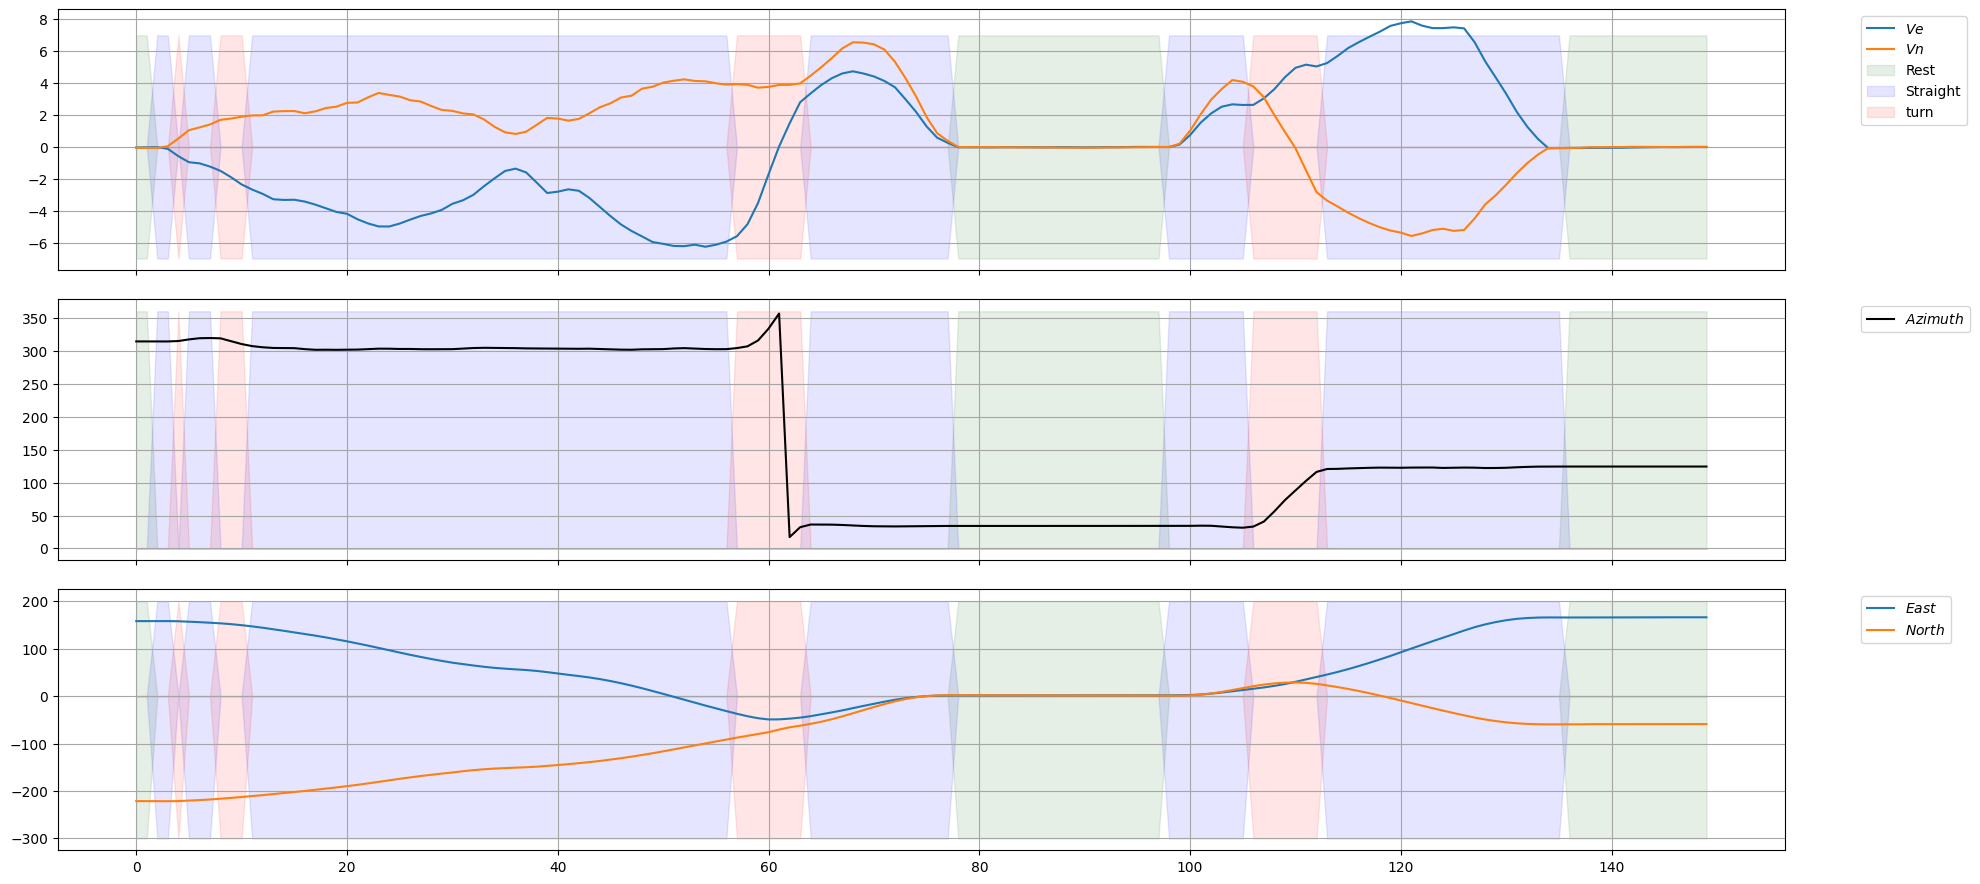

In [36]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(18,9), sharex='col')
fig.tight_layout()


axs[0].plot(df_gnss['t_rel'], df_gnss['ve'],  label=r'$Ve$')
axs[0].plot(df_gnss['t_rel'], df_gnss['vn'],  label=r'$Vn$')

axs[0].fill_between(df_gnss['t_rel'],-7*df_gnss['rest'], 7*df_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[0].fill_between(df_gnss['t_rel'], -7*df_gnss['straight' ], 7*df_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[0].fill_between(df_gnss['t_rel'],-7*df_gnss['turn'], 7*df_gnss['turn'], color='red', alpha=0.1, label='turn')

axs[1].plot(df_gnss['t_rel'], df_gnss['azimuth'],  color='k', label=r'$Azimuth$')
axs[1].fill_between(df_gnss['t_rel'], 0*df_gnss['rest'], 360*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[1].fill_between(df_gnss['t_rel'], 0*df_gnss['straight'], 360*df_gnss['straight'], color='blue', alpha=0.1, )
axs[1].fill_between(df_gnss['t_rel'], 0*df_gnss['turn'], 360*df_gnss['turn'], color='red', alpha=0.1, )

axs[2].plot(df_gnss['t_rel'], df_gnss['E'],  label=r'$East$')
axs[2].plot(df_gnss['t_rel'], df_gnss['N'],  label=r'$North$')
axs[2].fill_between(df_gnss['t_rel'], -300*df_gnss['rest'], 200*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[2].fill_between(df_gnss['t_rel'], -300*df_gnss['straight'], 200*df_gnss['straight'], color='blue', alpha=0.1, )
axs[2].fill_between(df_gnss['t_rel'], -300*df_gnss['turn'], 200*df_gnss['turn'], color='red', alpha=0.1, )

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')
    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')

        

In [37]:
imu_gnss = pd.merge(df_imu, 
                    df_gnss,
                    how='left',
                    left_on='time_sec',
                    right_on='time_sec',
                    suffixes=['_imu', '_gnss'],)

The right side of the dataset (GNSS side) represents the last GNSS measurement right before the current IMU data

In [38]:
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669,0.534768,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809,0.544746,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268,0.554702,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576,0.564667,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935,0.574855,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0


In [39]:
imu_gnss = imu_gnss[imu_gnss['time_ns_gnss'].notna()]
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669,0.534768,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809,0.544746,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268,0.554702,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576,0.564667,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935,0.574855,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0


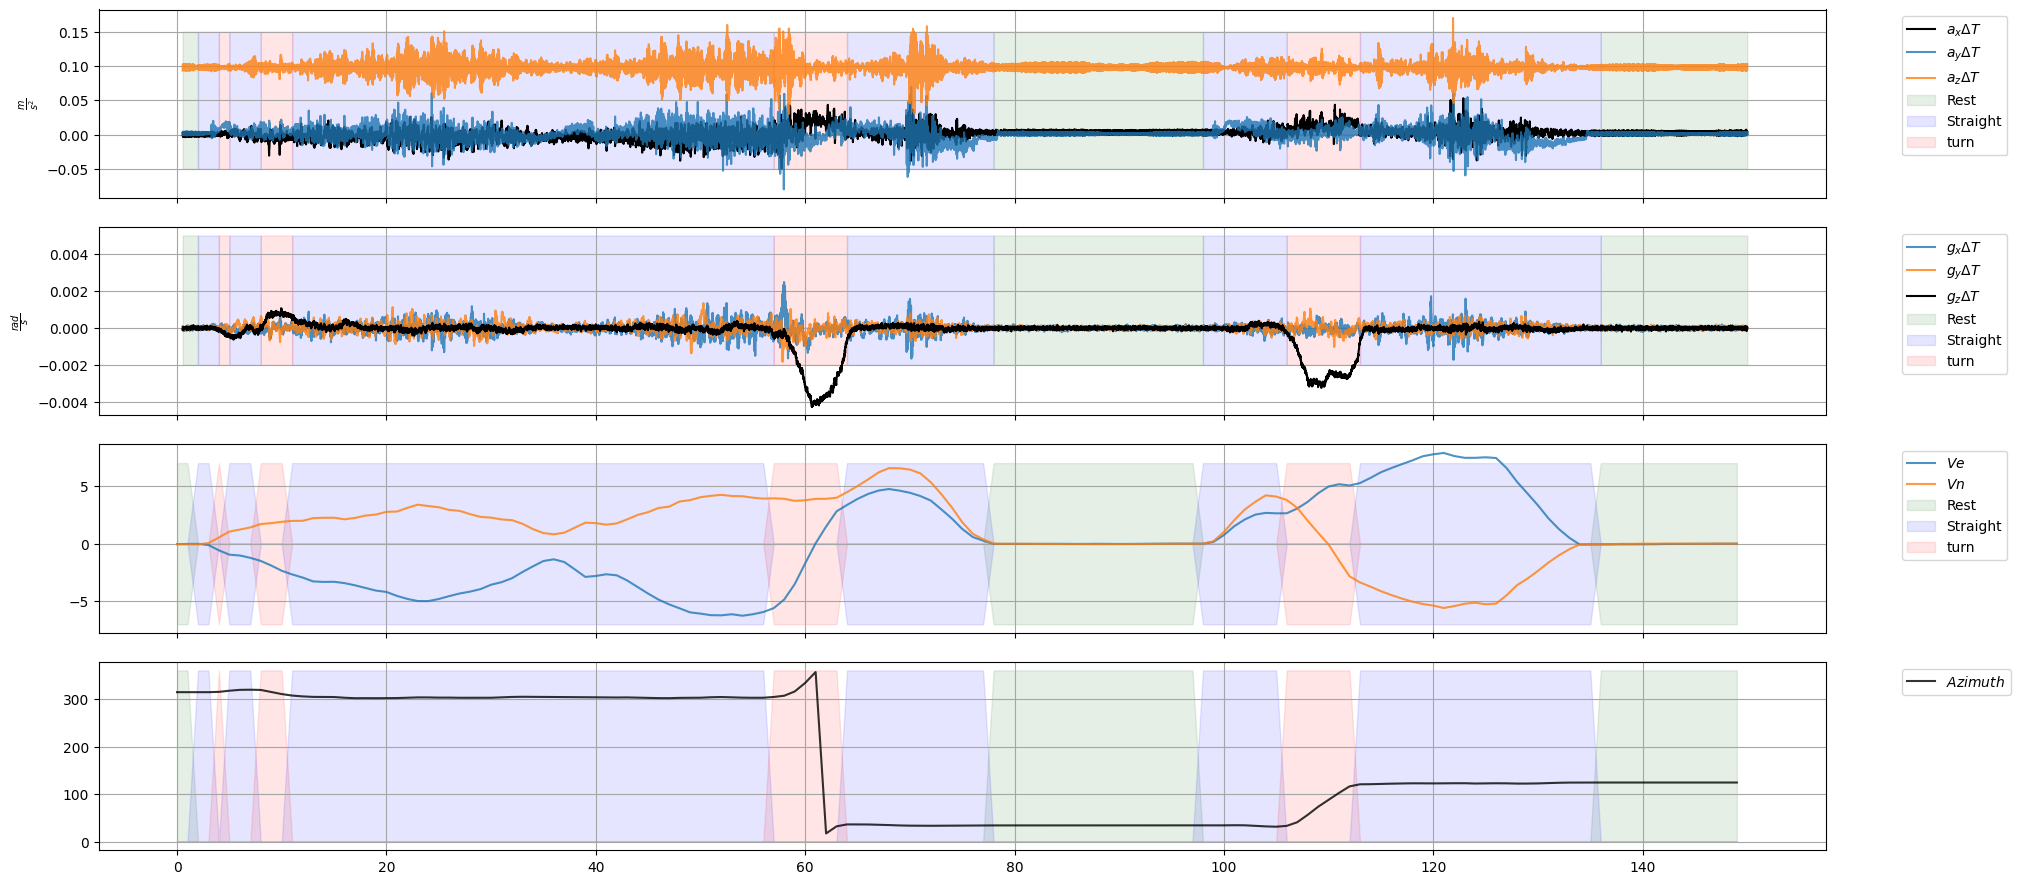

In [40]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18,9), sharex='col')
fig.tight_layout()

axs[0].plot(imu_gnss['t_rel_imu'], imu_gnss['axdt'],  label=r'$a_x \Delta T$', color='k')
axs[0].plot(imu_gnss['t_rel_imu'],imu_gnss['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
axs[0].plot(imu_gnss['t_rel_imu'], imu_gnss['azdt'], label=r'$a_z \Delta T$', alpha=0.8)
axs[0].fill_between(imu_gnss['t_rel_imu'],-5e-2*imu_gnss['rest'], 15e-2*imu_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[0].fill_between(imu_gnss['t_rel_imu'], -5e-2*imu_gnss['straight' ], 15e-2*imu_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[0].fill_between(imu_gnss['t_rel_imu'],-5e-2*imu_gnss['turn'],  15e-2*imu_gnss['turn'], color='red', alpha=0.1, label='turn')


axs[0].set_ylabel(r'$\frac{m}{s^2}$')

axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gzdt'],  label=r'$g_z \Delta T$', color='k')
axs[1].fill_between(imu_gnss['t_rel_imu'],-0.2e-2*imu_gnss['rest'], 0.5e-2*imu_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[1].fill_between(imu_gnss['t_rel_imu'], -0.2e-2*imu_gnss['straight' ], 0.5e-2*imu_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[1].fill_between(imu_gnss['t_rel_imu'],-0.2e-2*imu_gnss['turn'],  0.5e-2*imu_gnss['turn'], color='red', alpha=0.1, label='turn')
axs[1].set_ylabel(r'$\frac{rad}{s}$')


axs[2].plot(df_gnss['t_rel'], df_gnss['ve'],  label=r'$Ve$', alpha=0.8)
axs[2].plot(df_gnss['t_rel'], df_gnss['vn'],  label=r'$Vn$', alpha=0.8)
axs[2].fill_between(df_gnss['t_rel'],-7*df_gnss['rest'], 7*df_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[2].fill_between(df_gnss['t_rel'], -7*df_gnss['straight' ], 7*df_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[2].fill_between(df_gnss['t_rel'],-7*df_gnss['turn'], 7*df_gnss['turn'], color='red', alpha=0.1, label='turn')

axs[3].plot(df_gnss['t_rel'], df_gnss['azimuth'],  color='k', label=r'$Azimuth$', alpha=0.8)
axs[3].fill_between(df_gnss['t_rel'], 0*df_gnss['rest'], 360*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[3].fill_between(df_gnss['t_rel'], 0*df_gnss['straight'], 360*df_gnss['straight'], color='blue', alpha=0.1, )
axs[3].fill_between(df_gnss['t_rel'], 0*df_gnss['turn'], 360*df_gnss['turn'], color='red', alpha=0.1, )

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')
    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')

        

In [41]:
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az,t_rel,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669,0.534768,0.002342,-0.000540,0.093297,0.000059,0.000103,-0.000091,0.093328,0.000150
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809,0.544746,0.001771,0.003380,0.098988,0.000035,-0.000055,-0.000036,0.099062,0.000074
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268,0.554702,-0.002513,0.004239,0.102463,-0.000053,0.000048,-0.000018,0.102581,0.000074
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576,0.564667,-0.000838,0.001449,0.096336,-0.000028,0.000033,-0.000116,0.096350,0.000124
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935,0.574855,0.002996,-0.000243,0.093739,0.000005,0.000095,-0.000033,0.093788,0.000101


In [42]:
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669,0.534768,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809,0.544746,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268,0.554702,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576,0.564667,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935,0.574855,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0


In [43]:
imu_window_sum = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].sum()
imu_window_sum.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,0.006394,0.081056,4.600224,-0.001271,0.000601,-0.001101,4.602953,0.004064
1.0,0.017316,0.176440,9.790282,-0.001097,0.001590,-0.001171,9.795434,0.008478
2.0,0.017127,0.176695,9.788586,-0.001558,0.000661,-0.000909,9.793045,0.008932
3.0,0.032500,0.482298,9.784766,-0.000104,0.000501,-0.002057,9.808845,0.009974
4.0,0.072554,1.216363,9.795191,0.001055,0.000061,-0.027254,9.880517,0.030474


In [44]:
imu_window_var = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].var()
imu_window_var.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,0.000006,0.000003,0.000012,4.162347e-09,2.158534e-09,1.662997e-09,0.000012,1.818951e-09
1.0,0.000005,0.000002,0.000008,3.614823e-09,2.118414e-09,2.392751e-09,0.000008,1.380667e-09
2.0,0.000004,0.000001,0.000007,3.623142e-09,2.669124e-09,2.515259e-09,0.000007,1.120863e-09
3.0,0.000004,0.000021,0.000009,6.206409e-09,2.755071e-09,2.981368e-09,0.000009,2.348890e-09
4.0,0.000006,0.000014,0.000003,9.496197e-09,8.561489e-09,1.525361e-08,0.000003,1.464841e-08


In [45]:
imu_window_min = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].min()
imu_window_min.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,-0.003874,-0.001420,0.093108,-0.000179,-0.000105,-0.000116,0.093153,0.000020
1.0,-0.003610,-0.001127,0.093147,-0.000161,-0.000102,-0.000116,0.093168,0.000013
2.0,-0.003276,-0.000391,0.093406,-0.000144,-0.000107,-0.000110,0.093440,0.000033
3.0,-0.003829,-0.005365,0.092046,-0.000127,-0.000116,-0.000227,0.092092,0.000014
4.0,-0.005177,0.004268,0.093203,-0.000243,-0.000187,-0.000484,0.094830,0.000055


In [46]:
imu_window_max = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].max()
imu_window_max.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,0.003930,0.004634,0.102857,0.000082,0.000127,0.000083,0.102891,0.000189
1.0,0.003939,0.004913,0.102523,0.000145,0.000122,0.000154,0.102563,0.000162
2.0,0.003908,0.004152,0.102164,0.000162,0.000157,0.000116,0.102174,0.000179
3.0,0.004668,0.020014,0.102909,0.000229,0.000139,0.000106,0.103117,0.000243
4.0,0.005518,0.019253,0.102949,0.000252,0.000201,-0.000023,0.103888,0.000521


In [47]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,...,0,158.041110,-221.354305,-2.793024,0.060602,0.065327,314.263050,1,0,0
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,...,1,158.083880,-221.458712,-2.782896,0.065327,0.062689,314.262845,1,0,0
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,...,2,158.075701,-221.524258,-2.764028,0.062689,0.126796,314.230051,0,1,0
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,...,3,158.059610,-221.571997,-2.732539,0.126796,0.789580,314.867663,0,1,0
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,...,4,157.766013,-221.306961,-2.706395,0.789580,1.420646,317.301767,0,0,1


In [48]:
df_labels = df_gnss[['time','time_sec', 'time_ns', 'gnss_index', 'rest', 'straight','turn']].copy()
df_labels.head()

,time,time_sec,time_ns,gnss_index,rest,straight,turn
0,1.554024e+09,1554023732,0.0,0,1,0,0
1,1.554024e+09,1554023733,0.0,1,1,0,0
2,1.554024e+09,1554023734,0.0,2,0,1,0
3,1.554024e+09,1554023735,0.0,3,0,1,0
4,1.554024e+09,1554023736,0.0,4,0,0,1


In [49]:
# Add the features to the labels dataset
res_to_sffx = {
        '_sum': imu_window_sum,
        '_var': imu_window_var,
        '_min': imu_window_min,
        '_max': imu_window_max,
}
for key, _df in res_to_sffx.items():
    df_labels = pd.merge(
                left=df_labels,
                right=_df,
                left_on ='gnss_index',
                right_on='gnss_index',
                suffixes=[None, key]
    )

In [50]:
df_labels.head()

,time,time_sec,time_ns,gnss_index,rest,straight,turn,axdt,aydt,azdt,...,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max
0,1.554024e+09,1554023732,0.0,0,1,0,0,0.006394,0.081056,4.600224,...,0.093153,0.000020,0.003930,0.004634,0.102857,0.000082,0.000127,0.000083,0.102891,0.000189
1,1.554024e+09,1554023733,0.0,1,1,0,0,0.017316,0.176440,9.790282,...,0.093168,0.000013,0.003939,0.004913,0.102523,0.000145,0.000122,0.000154,0.102563,0.000162
2,1.554024e+09,1554023734,0.0,2,0,1,0,0.017127,0.176695,9.788586,...,0.093440,0.000033,0.003908,0.004152,0.102164,0.000162,0.000157,0.000116,0.102174,0.000179
3,1.554024e+09,1554023735,0.0,3,0,1,0,0.032500,0.482298,9.784766,...,0.092092,0.000014,0.004668,0.020014,0.102909,0.000229,0.000139,0.000106,0.103117,0.000243
4,1.554024e+09,1554023736,0.0,4,0,0,1,0.072554,1.216363,9.795191,...,0.094830,0.000055,0.005518,0.019253,0.102949,0.000252,0.000201,-0.000023,0.103888,0.000521


In [51]:
df_labels['gnss_index_start'] = df_labels['gnss_index'].copy()
df_labels['gnss_index_end'] = df_labels['gnss_index_start'] + 1

In [52]:
df_labels.head()

,time,time_sec,time_ns,gnss_index,rest,straight,turn,axdt,aydt,azdt,...,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max,gnss_index_start,gnss_index_end
0,1.554024e+09,1554023732,0.0,0,1,0,0,0.006394,0.081056,4.600224,...,0.003930,0.004634,0.102857,0.000082,0.000127,0.000083,0.102891,0.000189,0,1
1,1.554024e+09,1554023733,0.0,1,1,0,0,0.017316,0.176440,9.790282,...,0.003939,0.004913,0.102523,0.000145,0.000122,0.000154,0.102563,0.000162,1,2
2,1.554024e+09,1554023734,0.0,2,0,1,0,0.017127,0.176695,9.788586,...,0.003908,0.004152,0.102164,0.000162,0.000157,0.000116,0.102174,0.000179,2,3
3,1.554024e+09,1554023735,0.0,3,0,1,0,0.032500,0.482298,9.784766,...,0.004668,0.020014,0.102909,0.000229,0.000139,0.000106,0.103117,0.000243,3,4
4,1.554024e+09,1554023736,0.0,4,0,0,1,0.072554,1.216363,9.795191,...,0.005518,0.019253,0.102949,0.000252,0.000201,-0.000023,0.103888,0.000521,4,5


In [53]:
rename_map = {}
for col in ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'a', 'g']:
    rename_map[col+'dt'] = col+'dt_sum'
rename_map

{'axdt': 'axdt_sum',
 'aydt': 'aydt_sum',
 'azdt': 'azdt_sum',
 'gxdt': 'gxdt_sum',
 'gydt': 'gydt_sum',
 'gzdt': 'gzdt_sum',
 'adt': 'adt_sum',
 'gdt': 'gdt_sum'}

In [54]:
df_results = df_labels.rename(rename_map, axis=1).copy()

In [55]:
df_results.head()

,time,time_sec,time_ns,gnss_index,rest,straight,turn,axdt_sum,aydt_sum,azdt_sum,...,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max,gnss_index_start,gnss_index_end
0,1.554024e+09,1554023732,0.0,0,1,0,0,0.006394,0.081056,4.600224,...,0.003930,0.004634,0.102857,0.000082,0.000127,0.000083,0.102891,0.000189,0,1
1,1.554024e+09,1554023733,0.0,1,1,0,0,0.017316,0.176440,9.790282,...,0.003939,0.004913,0.102523,0.000145,0.000122,0.000154,0.102563,0.000162,1,2
2,1.554024e+09,1554023734,0.0,2,0,1,0,0.017127,0.176695,9.788586,...,0.003908,0.004152,0.102164,0.000162,0.000157,0.000116,0.102174,0.000179,2,3
3,1.554024e+09,1554023735,0.0,3,0,1,0,0.032500,0.482298,9.784766,...,0.004668,0.020014,0.102909,0.000229,0.000139,0.000106,0.103117,0.000243,3,4
4,1.554024e+09,1554023736,0.0,4,0,0,1,0.072554,1.216363,9.795191,...,0.005518,0.019253,0.102949,0.000252,0.000201,-0.000023,0.103888,0.000521,4,5


In [56]:
def motion_state_str(row: pd.Series) -> str:
    if row['rest']:
        return 'rest'
    if row['straight']:
        return 'straight'
    if row['turn']:
        return 'turn'

In [57]:
df_results['motion_state'] = df_results.apply(lambda x: motion_state_str(x), axis=1)

In [58]:
feature_target_cols = 'motion_state,axdt_sum,aydt_sum,azdt_sum,gxdt_sum,gydt_sum,gzdt_sum,adt_sum,gdt_sum,axdt_var,aydt_var,azdt_var,gxdt_var,gydt_var,gzdt_var,adt_var,gdt_var,axdt_min,aydt_min,azdt_min,gxdt_min,gydt_min,gzdt_min,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max'.split(',')
feature_target_cols 

['motion_state',
 'axdt_sum',
 'aydt_sum',
 'azdt_sum',
 'gxdt_sum',
 'gydt_sum',
 'gzdt_sum',
 'adt_sum',
 'gdt_sum',
 'axdt_var',
 'aydt_var',
 'azdt_var',
 'gxdt_var',
 'gydt_var',
 'gzdt_var',
 'adt_var',
 'gdt_var',
 'axdt_min',
 'aydt_min',
 'azdt_min',
 'gxdt_min',
 'gydt_min',
 'gzdt_min',
 'adt_min',
 'gdt_min',
 'axdt_max',
 'aydt_max',
 'azdt_max',
 'gxdt_max',
 'gydt_max',
 'gzdt_max',
 'adt_max',
 'gdt_max']

In [59]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              150 non-null    float64
 1   time_sec          150 non-null    int64  
 2   time_ns           150 non-null    float64
 3   gnss_index        150 non-null    int64  
 4   rest              150 non-null    int64  
 5   straight          150 non-null    int64  
 6   turn              150 non-null    int64  
 7   axdt_sum          150 non-null    float64
 8   aydt_sum          150 non-null    float64
 9   azdt_sum          150 non-null    float64
 10  gxdt_sum          150 non-null    float64
 11  gydt_sum          150 non-null    float64
 12  gzdt_sum          150 non-null    float64
 13  adt_sum           150 non-null    float64
 14  gdt_sum           150 non-null    float64
 15  axdt_var          150 non-null    float64
 16  aydt_var          150 non-null    float64
 1

In [60]:
df_results[feature_target_cols].to_csv('data/testing.csv', index=False)